**Table of contents**<a id='toc0_'></a>    
- [Notes](#toc1_)    
  - [To do](#toc1_1_)    
- [Package instalation](#toc2_)    
- [1. Test No data frame single likelihood](#toc3_)    
- [2. Test without data frame & with multiple likelihood](#toc4_)    
- [3. Test with data frame in likelihood](#toc5_)    
- [4. Indices](#toc6_)    
- [5. Model comparaison](#toc7_)    
- [6. Multiple indices](#toc8_)    
- [Categorical interactions](#toc9_)    
- [ 8. Continuous interactions](#toc10_)    
- [9. Binomial model](#toc11_)    
- [10. Binomial with index](#toc12_)    
- [11. Poisson](#toc13_)    
- [12. This doesn't work due to 'P^' WIP: need to implement mathematical operation within formulas](#toc14_)    
- [13. Negative binomial (PB estimation)](#toc15_)    
- [14. Multinomial](#toc16_)    
  - [14.1. Categorical models (WIP: tfd.multinomial to handle)](#toc16_1_)    
  - [14.2. Multinomial in disguise as Binomial](#toc16_2_)    
  - [14.3. Multinomial in disguise as Poisson](#toc16_3_)    
- [15. Beta binomial](#toc17_)    
- [16. Zero-inflated outcomes](#toc18_)    
  - [Using ZeroInflatedNegativeBinomial function](#toc18_1_)    
  - [Using Inflated function](#toc18_2_)    
- [17. Ordered categorical outcomes (TODO)](#toc19_)    
- [18. Ordered categorical predictors (TODO)](#toc20_)    
- [19. Varying Intercepts Models](#toc21_)    
- [20. Varying effects](#toc22_)    
- [21. Multiple random effects (TODO)](#toc23_)    
- [22. Partial pooling for network ties (TODO)](#toc24_)    
- [23. Gaussian Processes (TODO)](#toc25_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Notes](#toc0_)

- Gpu computation is not always better, it depends of your model size: https://stackoverflow.com/questions/55749899/training-a-simple-model-in-tensorflow-gpu-slower-than-cpu

- Depending on the float precision model outputs may differ.

- Data frame need to be set with correct types (int, float) otherwise model outputs may differ.


## <a id='toc1_1_'></a>[To do](#toc0_)
    1.  Redo GUI
    2.  Help functions
    3.  Documentation
    4.  Multinomial models to be run with Multinomial distribution
    5.  Multiple likelihoods can have different types: independent models -> independent HMC, dependent priors -> 
    6.  Posterior need to handle multiple likelihood
    7. Implementation of additional MCMC sampling methods
    8. Float precision to handle

Current WIP BetaBinomial, require to handle multiple likelihoods

# <a id='toc2_'></a>[Package instalation](#toc0_)

In [ ]:
#try:
#  %pip install tensorflow tensorflow_probability pandas numpy arviz seaborn functools matplotlib.pyplot
#  %pip install git+https://github.com/BGN-for-ASNA/BI.git
#except:
#  pass

# <a id='toc3_'></a>[1. Test No data frame single likelihood](#toc0_)

In [2]:
from ..src import main

ImportError: attempted relative import with no known parent package

In [48]:
from BI.src import main

ModuleNotFoundError: No module named 'BI'

In [35]:
formula = dict(main = 'y~Normal(m,s)',
            likelihood = 'm ~  alpha + beta',
            prior1 = 's~Exponential(1)',
            prior2 = 'alpha ~ Normal(0,1)',
            prior3 = 'beta ~ Normal(0,1)')  
self = model(formula= formula, float = 16) 
self.sample()

NameError: name 'model' is not defined

# <a id='toc4_'></a>[2. Test without data frame & with multiple likelihood](#toc0_)

In [2]:
from  src.main import *
formula = dict(main = 'y~Normal(m,s)',
            likelihood = 'm ~  alpha + beta',
            prior1 = 's~Exponential(1)',
            prior2 = 'alpha ~ Normal(0,1)',
            prior3 = 'beta ~ Normal(0,1)',
            
            main1 = 'z~Normal(m2,s2)',
            likelihood2 = 'm2 ~ alpha2 + beta2',
            prior4 = 's2~Exponential(1)',
            prior5 = 'alpha2 ~ Normal(0,1)',
            prior6 = 'beta2 ~ Normal(0,1)') 
self = model(formula= formula, float = 16)
self.log_prob(self.sample(10))

2024-02-27 10:38:52.597264: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:38:52.597312: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:38:52.597329: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:38:52.597487: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:38:52.597499: I tensorflow/core/common_runtime/gpu/gpu

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-13.665064 ,  -8.107071 ,  -6.281726 ,  -6.8278356, -10.6313095,
       -11.272713 , -18.96839  ,  -8.30773  ,  -9.053262 , -11.686344 ],
      dtype=float32)>

# <a id='toc5_'></a>[3. Test with data frame in likelihood](#toc0_)

In [2]:
from  src.main import *
## Model m4.3
d = pd.read_csv('./data/Howell1.csv', sep=';')
d = d[d.age > 18]
#self.df["weight.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d.weight = d.weight - d.weight.mean()
d.age = d.age - d.age.mean()
formula = dict(main1 = 'height ~ Normal(mu,sigma)',
            likelihood = 'mu ~ alpha + beta * weight',
            prior1 = 'sigma ~ Uniform(0,50)',
            prior2 = 'alpha ~ Normal(178,20)',
            prior3 = 'beta ~ Normal(0,1)')    

self = model(formula, df = d, float = 32)
self.fit(observed_data = dict(height =d.height.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
self.summary()

# expected 
#           Mean    StdDev  5.5%    94.5%   a   b   sigma
#   a       154.60  0.27    154.17  155.03  1   0   0
#   b       0.91    0.04    0.84    0.97    0   1   0
#   sigma   5.07    0.19    4.77    5.38    0   0   1

2024-02-27 10:39:40.260684: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:40.260736: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:40.260749: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:40.260911: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:40.260922: I tensorflow/core/common_runtime/gpu/gpu

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_1' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_2' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]


,mean,sd,hdi_5.5%,hdi_94.5%
sigma[0],5.14,0.19,4.82,5.44
beta[0],0.91,0.04,0.83,0.97
alpha[0],154.64,0.28,154.20,155.08


# <a id='toc6_'></a>[4. Indices](#toc0_)

In [3]:
## Model m5.9 
from src.main import *
self = model()
self.import_csv('./data/milk.csv', sep = ';')
self.df["K"] = self.df["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
self.index(cols = "clade")
formula = dict(main = 'K ~ Normal(mu,sigma)',
            likelihood = 'mu ~ alpha[index_clade]',
            prior1 = 'alpha~ Normal(0,0.5)',
            prior2 = 'sigma ~ Exponential(1)') 

self.f = formula
self.build_model()
self.fit(observed_data = dict(K =self.df.K.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
self.summary()

# Expected:
#                mean	sd	    hdi_5.5%	hdi_94.5%
# ape_alpha	    -0.48	0.27	-0.93	    -0.08
# nwm_alpha	    0.37	0.22	0.03	    0.73
# owm_alpha	    0.65	0.30	0.26	    1.18
# strep_alpha	-0.55	0.29	-1.07	    -0.19
# sigma	        0.83	0.13	0.67	    1.06

2024-02-27 10:39:45.574478: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:45.574527: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:45.574539: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:45.574657: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:45.574662: I tensorflow/core/common_runtime/gpu/gpu

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_1' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]


,mean,sd,hdi_5.5%,hdi_94.5%
sigma[0],0.80,0.12,0.61,0.97
alpha[0],-0.46,0.24,-0.84,-0.08
alpha[1],0.35,0.24,-0.01,0.74
alpha[2],0.64,0.28,0.20,1.08
alpha[3],-0.55,0.29,-1.01,-0.08


# <a id='toc7_'></a>[5. Model comparaison](#toc0_)

In [4]:
from  src.main import*
# m8.1
m = model()
d = pd.read_csv('./data/rugged.csv', sep = ';')
# make log version of outcome
d['log_gdp'] = np.log(d.rgdppc_2000)
# extract countries with GDP data

# rescale variables
d['log_gdp_std'] = d["log_gdp"].pipe(lambda x: (x / x.mean()) )
d['rugged_std'] = d["rugged"].pipe(lambda x: (x / x.max()) )
d['rugged_std'] - 0.215
d = d.loc[:,['rugged_std','log_gdp_std', 'cont_africa','log_gdp']]
d = d.dropna()

formula = dict(
    main = 'log_gdp_std ~ Normal( mu , sigma ) ',
    likelihood = 'mu ~ a + b* rugged_std ',
    prior1 = 'a ~ Normal( 1 , 0.1  )' ,
    prior2 = 'b ~ Normal( 0 , 0.3 )' ,
    prior3 = 'sigma ~ Exponential( 1 )'
)

m8_1 = model(formula, d)

m8_1.fit(observed_data = dict(log_gdp_std =d.log_gdp_std.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m8_1.summary()

#Expected:
#       mean    sd      5.5%    94.5%
#a      1.00    0.01    0.98    1.0
#b      0.00    0.05    -0.09   0.09
#sigma  0.14    0.01    0.12    0.15


2024-02-27 10:39:49.778928: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:49.778980: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:49.778997: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:49.779176: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:49.779188: I tensorflow/core/common_runtime/gpu/gpu

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_1' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_2' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]


,mean,sd,hdi_5.5%,hdi_94.5%
sigma[0],0.12,0.04,0.05,0.15
b[0],0.03,0.06,-0.10,0.09
a[0],0.96,0.07,0.84,1.01


In [5]:

d = pd.read_csv('./data/rugged.csv', sep = ';')
d["log_gdp"] = d["rgdppc_2000"].pipe(np.log)

# extract countries with GDP data
dd = d[d["rgdppc_2000"].notnull()].copy()

# rescale variables
dd["log_gdp_std"] = dd.log_gdp / dd.log_gdp.mean()
dd["rugged_std"] = dd.rugged / dd.rugged.max()

dd["cid"] = np.where(dd.cont_africa.values == 1, 0, 1)
dd["cid"]

formula = dict(
    main = 'log_gdp_std ~ Normal( mu , sigma ) ',
    likelihood = 'mu ~ a[cid] + b*rugged_std',
    prior1 = 'a ~ Normal( 1 , 0.1  )' ,
    prior2 = 'b ~ Normal( 0 , 0.3 )' ,
    prior3 = 'sigma ~ Exponential( 1 )'
)

m8_2= model(formula, dd)
m8_2.fit(observed_data = dict(log_gdp_std =dd.log_gdp_std.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m8_2.summary()

#Expected:
#       mean    sd      5.5%    94.5%
#a[1]   0.88    0.02    0.85    0.91
#a[2]   1.05    0.01    1.03    1.07
#b      -0.05   0.05    -0.12   0.03
#sigma  0.11    0.01    0.10    0.1


2024-02-27 10:39:54.618797: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:54.618862: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:54.618880: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:54.619029: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:54.619042: I tensorflow/core/common_runtime/gpu/gpu

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_1' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_2' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]


,mean,sd,hdi_5.5%,hdi_94.5%
sigma[0],0.11,0.01,0.10,0.12
b[0],-0.05,0.05,-0.13,0.02
a[0],0.89,0.02,0.86,0.92
a[1],1.06,0.01,1.03,1.08


In [6]:
m8_2.diag_compare({'m8.1': m8_1.trace, 'm8.2': m8_2.trace})
#       rank	elpd_loo	p_loo	    elpd_diff	weight	se	    dse	    warning	    scale
#m8.2	0	    128.021790	3.008224	0.000000	1.0	    0.0	    0.0	    True	    log
#m8.1	1	    95.414886	2.317650	32.606903	0.0	    0.0	    0.0	    True	    log

/home/sosa/.local/lib/python3.10/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/sosa/.local/lib/python3.10/site-packages/arviz/stats/stats.py:839: UserWarning: The point-wise LOO is the same with the sum LOO, please double check the Observed RV in your model to make sure it returns element-wise logp.
  warnings.warn(
/home/sosa/.local/lib/python3.10/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well i

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m8.2,0,128.38559,2.656433,0.00000,1.0,0.0,0.0,True,log
m8.1,1,-957.94342,1055.429298,1086.32901,0.0,0.0,0.0,True,log


# <a id='toc8_'></a>[6. Multiple indices](#toc0_)

In [7]:
# m8.3
from src.main import*
d = pd.read_csv('./data/rugged.csv', sep = ';')
d["log_gdp"] = d["rgdppc_2000"].pipe(np.log)

# extract countries with GDP data
dd = d[d["rgdppc_2000"].notnull()].copy()

# rescale variables
dd["log_gdp_std"] = dd.log_gdp / dd.log_gdp.mean()
dd["rugged_std"] = dd.rugged / dd.rugged.max()

dd["cid"] = np.where(dd.cont_africa.values == 1, 0, 1)

formula = dict(
    main = 'log_gdp_std ~ Normal( mu , sigma ) ',
    likelihood = 'mu ~ a[cid] + b[cid]*rugged_std',
    prior1 = 'a ~ Normal( 1 , 0.1  )' ,
    prior2 = 'b ~ Normal( 0 , 0.3 )' ,
    prior3 = 'sigma ~ Exponential( 1 )'
)

m8_3 = model(formula, dd)

m8_3.fit(observed_data = dict(log_gdp_std =dd.log_gdp_std.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m8_3.summary()

# Expected:
#       mean    sd      5.5%    94.5%
#a[1]   0.89    0.02    0.86    0.91
#a[2]   1.05    0.01    1.03    1.07
#b[1]   0.13    0.07    0.01    0.25
#b[2]   -0.14   0.05    -0.23    -0.06
#sigma  0.11    0.01    0.10    0.12

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_1' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_2' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]


2024-02-27 10:39:59.852919: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:59.852986: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:59.853004: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:59.853144: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:39:59.853150: I tensorflow/core/common_runtime/gpu/gpu

,mean,sd,hdi_5.5%,hdi_94.5%
sigma[0],0.11,0.01,0.10,0.12
b[0],0.12,0.07,-0.00,0.23
b[1],-0.13,0.06,-0.23,-0.05
a[0],0.86,0.02,0.83,0.89
a[1],1.08,0.02,1.05,1.10


# <a id='toc9_'></a>[Categorical interactions](#toc0_)

In [8]:
from src.main import*
d = pd.read_csv('./data/tulips.csv', sep = ';')
d["blooms_std"] = d.blooms / d.blooms.max()
d["water_cent"] = d.water - d.water.mean()
d["shade_cent"] = d.shade - d.shade.mean()

d["water_cent"] = d["water_cent"].astype(int)
d["shade_cent"] = d["shade_cent"].astype(int)
formula = dict(
            main = 'blooms_std ~ Normal( mu , sigma ) ',
            likelihood ='mu ~ a + bw*water_cent + bs*shade_cent' ,
            prior1 = 'a ~ Normal( 0.5 , 0.25 ) ',
            prior2 = 'bw ~ Normal( 0 , 0.25 ) ',
            prior3 = 'bs ~ Normal( 0 , 0.25 ) ',
            prior4 = 'sigma ~ Exponential( 1 )',
            )
m8_4 = model(formula, d)
m8_4.fit(observed_data = dict(blooms_std =d.blooms_std.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m8_4.summary()
#Expected:
#       mean   sd       5.5%    94.5%
#a      0.36    0.03     0.31    0.41
#bw     0.21    0.04     0.15    0.26
#bs    -0.11    0.04    -0.17   -0.05
#sigma  0.16    0.02     0.12    0.19

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_1' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_2' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_3' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]


2024-02-27 10:40:04.865782: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:04.865845: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:04.865857: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:04.866008: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:04.866020: I tensorflow/core/common_runtime/gpu/gpu

,mean,sd,hdi_5.5%,hdi_94.5%
sigma[0],0.18,0.03,0.14,0.22
bw[0],0.20,0.04,0.14,0.27
bs[0],-0.11,0.04,-0.18,-0.05
a[0],0.36,0.03,0.30,0.41


# <a id='toc10_'></a>[ 8. Continuous interactions](#toc0_)

In [9]:
## Model m8.3
d = pd.read_csv('./data/tulips.csv', sep = ';')
d["blooms_std"] = d.blooms / d.blooms.max()
d["water_cent"] = d.water - d.water.mean()
d["shade_cent"] = d.shade - d.shade.mean()

formula = dict(
            main = 'blooms_std ~ Normal( mu , sigma ) ',
            likelihood ='mu ~ a + bw*water_cent + bs*shade_cent + bws*water_cent*shade_cent' ,
            prior1 = 'a ~ Normal( 0.5 , 0.25 ) ',
            prior2 = 'bw ~ Normal( 0 , 0.25 ) ',
            prior3 = 'bs ~ Normal( 0 , 0.25 ) ',
            prior4 = 'bws ~ Normal( 0 , 0.25 ) ',
            prior5 = 'sigma ~ Exponential( 1 )',
            )
m8_5 = model(formula, d)
m8_5.fit(observed_data = dict(blooms_std =d.blooms_std.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m8_5.summary()

# Expected
#       mean   sd  5.5% 94.5%
#a      0.36 0.02  0.32  0.40
#bw     0.21 0.03  0.16  0.25
#bs    -0.11 0.03 -0.16 -0.07
#bws   -0.14 0.04 -0.20 -0.09
#sigma  0.12 0.02  0.10  0.15

2024-02-27 10:40:10.803982: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:10.804049: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:10.804063: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:10.804214: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:10.804226: I tensorflow/core/common_runtime/gpu/gpu

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_1' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_2' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_3' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_4' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]


,mean,sd,hdi_5.5%,hdi_94.5%
sigma[0],0.14,0.02,0.11,0.17
bws[0],-0.14,0.04,-0.21,-0.08
bw[0],0.21,0.03,0.15,0.26
bs[0],-0.11,0.03,-0.16,-0.06
a[0],0.36,0.03,0.32,0.40


# <a id='toc11_'></a>[9. Binomial model](#toc0_)

In [10]:
from src.main import*
d = pd.read_csv('./data/chimpanzees.csv', sep = ';')
d["treatment"] = 1 + d.prosoc_left + 2 * d.condition
d["side"] = d.prosoc_left  # right 0, left 1
d["cond"] = d.condition  # no partner 0, partner 1

d_aggregated = (
    d.groupby(["treatment", "actor", "side", "cond"])["pulled_left"].sum().reset_index()
)
d_aggregated.rename(columns={"pulled_left": "left_pulls"}, inplace=True)
d_aggregated["actor_id"] = d_aggregated["actor"].values - 1

formula = dict(
    main = 'pulled_left ~ Binomial( 1 , logits = p )' ,
    likelihood = 'p ~ a' ,
    prior1 = 'a ~ Normal( 0 , 10 )'
)

m11_1 = model(formula, d)
m11_1.fit(observed_data = dict(pulled_left =d.pulled_left.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m11_1.summary()
# expected
#  mean   sd 5.5% 94.5%
#a 0.32 0.09 0.18  0.46

2024-02-27 10:40:17.781341: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:17.781409: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:17.781422: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:17.781529: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:17.781534: I tensorflow/core/common_runtime/gpu/gpu

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]


,mean,sd,hdi_5.5%,hdi_94.5%
a[0],0.32,0.09,0.17,0.46


# <a id='toc12_'></a>[10. Binomial with index](#toc0_)

In [11]:
from src.main import*
d = pd.read_csv('./data/chimpanzees.csv', sep = ';')
d.actor = d.actor - 1
d["treatment"] = d.prosoc_left + 2 * d.condition
d[["actor", "prosoc_left", "condition", "treatment"]]

formula = dict(
    main = 'pulled_left ~ Binomial(1 , p )' ,
    likelihood = 'p ~ a[actor] + b[treatment]' ,
    prior1 = 'a ~ Normal(0,1.5)',
    prior2 = 'b ~ Normal(0,0.5)'
)
m11_4 = model(formula, d, float = 32)
m11_4.fit(observed_data = dict(pulled_left =d.pulled_left.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m11_4.summary()
# Expected
#          mean    sd   5.5%    94.5%   n_eff Rhat
#a[1]   -0.45    0.32   -0.95    0.04   690 1
#a[2]   3.86     0.73   2.78     5.09   1417 1
#a[3]   -0.75    0.33   -1.28    -0.23   765 1
#a[4]   -0.74    0.33   -1.26    -0.21   887 1
#a[5]   -0.44    0.32   -0.94    0.10   743 1
#a[6]   0.48     0.32   -0.02    1.00   894 1
#a[7]   1.95     0.40   1.32    2.63    882 1
#b[1]   -0.04    0.28   -0.51    0.40   669 1
#b[2]   0.48     0.28   0.04    0.92    675 1
#b[3]   -0.38    0.28   -0.83    0.06    768 1
#b[4]   0.37     0.27   -0.07    0.79   666 1


2024-02-27 10:40:21.621897: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:21.621958: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:21.621972: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:21.622118: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:21.622129: I tensorflow/core/common_runtime/gpu/gpu

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_1' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]


,mean,sd,hdi_5.5%,hdi_94.5%
b[0],-0.04,0.29,-0.52,0.40
b[1],0.48,0.29,0.04,0.94
b[2],-0.38,0.29,-0.85,0.07
b[3],0.37,0.28,-0.05,0.85
a[0],-0.45,0.33,-0.94,0.11
a[1],3.88,0.74,2.73,5.06
a[2],-0.75,0.34,-1.31,-0.21
a[3],-0.75,0.33,-1.26,-0.22
a[4],-0.45,0.33,-0.96,0.11
a[5],0.48,0.34,-0.06,1.01


array([<Axes: >, <Axes: title={'center': 'ess'}>], dtype=object)

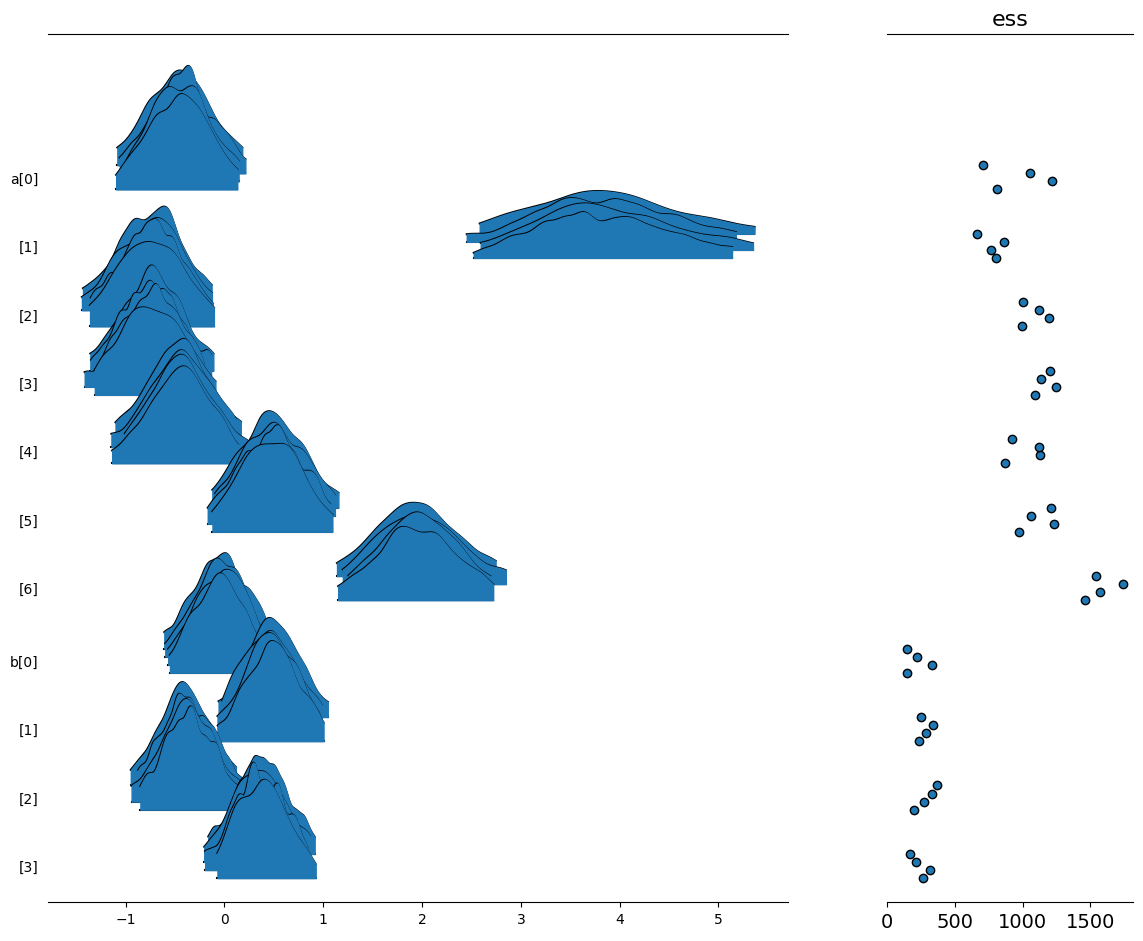

In [12]:
az.plot_forest(m11_4.trace, var_names = ['a','b'],  kind = 'ridgeplot', ess = True)

# <a id='toc13_'></a>[11. Poisson](#toc0_)

In [13]:
from src.main import*
d = pd.read_csv('./data/Kline.csv', sep = ';')
d["P"] = d.population.pipe(np.log).pipe(lambda x: (x - x.mean()) / x.std())
d["cid"] = (d.contact == "high").astype(int)
d['pLog'] = tf.math.log(d.P).numpy()
formula = dict(main = 'total_tools ~ Poisson(log_rate = LL)',
               likelihood = 'LL ~ alpha',
               prior1 = 'alpha ~ Normal(3,0.5)')
m11_9 = model(formula, d)
m11_9.fit(observed_data = dict(total_tools =d.total_tools.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m11_9.summary()
#Expected
#  mean   sd 5.5% 94.5% rhat ess_bulk
#a 3.54 0.05 3.46  3.63 1.01   679.05

2024-02-27 10:40:29.329519: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:29.329591: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:29.329608: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:29.329838: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:29.329850: I tensorflow/core/common_runtime/gpu/gpu

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]


,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],3.54,0.05,3.45,3.62


In [14]:
formula = dict(main = 'total_tools ~ Poisson(log_rate = lambda)',
               likelihood = 'lambda ~ alpha[cid] + beta[cid]*P',
               prior1 = 'alpha ~ Normal(3,0.5)',
               prior2 = 'beta ~ Normal(0,0.2)')
m11_10 = model(formula, d)
m11_10.fit(observed_data = dict(total_tools =d.total_tools.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m11_10.summary()
# Expected
#     mean   sd     5.5%    94.5% rhat ess_bulk
#a[1] 3.32  0.09     3.19   3.46    1  1553.42
#a[2] 3.61  0.07     3.49   3.73    1  2004.06
#b[1] 0.38  0.05     0.29   0.46    1  1769.96
#b[2] 0.18  0.16    -0.07   0.45    1  1747.86

2024-02-27 10:40:32.642209: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:32.642265: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:32.642280: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:32.642418: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:32.642423: I tensorflow/core/common_runtime/gpu/gpu

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_1' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]


,mean,sd,hdi_5.5%,hdi_94.5%
beta[0],0.38,0.05,0.29,0.46
beta[1],0.19,0.16,-0.07,0.43
alpha[0],3.32,0.09,3.18,3.46
alpha[1],3.61,0.07,3.50,3.73


# <a id='toc14_'></a>[12. This doesn't work due to 'P^' WIP: need to implement mathematical operation within formulas](#toc0_)

In [15]:
from src.main import*
d = pd.read_csv('./data/Kline.csv', sep = ';')
d["P"] = d.population.pipe(np.log).pipe(lambda x: (x - x.mean()) / x.std())
d["cid"] = (d.contact == "high").astype(int)
d['pLog'] = tf.math.log(d.P).numpy()
formula = dict(main = 'total_tools ~ Poisson(log_rate = lambda)',
               likelihood = 'lambda ~ alpha[cid] +  P^beta[cid]',
               prior1 = 'alpha ~ Normal(3.,0.5)',
               prior2 = 'beta ~ Normal(0,0.2)')
m11_11 = model(formula, d)


2024-02-27 10:40:37.257980: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:37.258045: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:37.258060: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:37.258193: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:37.258205: I tensorflow/core/common_runtime/gpu/gpu

# <a id='toc15_'></a>[13. Negative binomial (PB estimation)](#toc0_)

In [16]:
from src.main import*
num_days = 30
y = tfd.Poisson(rate=1.5).sample((num_days,))
num_weeks = 4
y_new = tfd.Poisson(rate=0.5 * 7).sample((num_weeks,))
y_all = np.concatenate([y, y_new])
exposure = np.concatenate([np.repeat(1, 30), np.repeat(7, 4)])
monastery = np.concatenate([np.repeat(0, 30), np.repeat(1, 4)])
d = pd.DataFrame.from_dict(dict(y=y_all, days=exposure, monastery=monastery))
d["log_days"] = d.days.pipe(np.log)


formula = dict(main = 'y ~ Poisson(log_rate = lambda)',
               likelihood = 'lambda ~ log_days + alpha +  beta * monastery',
               prior1 = 'alpha ~ Normal(0,1)',
               prior2 = 'beta ~ Normal(0,1)')

m11_12 = model(formula, d, float=32)
m11_12.fit(observed_data = dict(y =d.y.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m11_12.summary()
# Expected
#   mean    sd      5.5%    94.5%
#a  0.37    0.15     0.13    0.61
#b -1.13    0.30    -1.61   -0.65

2024-02-27 10:40:38.756552: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:38.756625: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:38.756640: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:38.756755: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:38.756761: I tensorflow/core/common_runtime/gpu/gpu

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_1' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]


,mean,sd,hdi_5.5%,hdi_94.5%
beta[0],-1.24,0.27,-1.69,-0.81
alpha[0],0.38,0.14,0.16,0.60


# <a id='toc16_'></a>[14. Multinomial](#toc0_)

## <a id='toc16_1_'></a>[14.1. Categorical models (WIP: tfd.multinomial to handle)](#toc0_)

In [17]:
from src.main import*
# simulate career choices among 500 individuals
N = 500  # number of individuals
income = np.array([1, 2, 5])  # expected income of each career
score = 0.5 * income  # scores for each career, based on income

# next line converts scores to probabilities
p = tf.nn.softmax(score)

# now simulate choice
# outcome career holds event type values, not counts
career = np.repeat(np.nan, N)  # empty vector of choices for each individual

# sample chosen career for each individual
for i in range(N):
    career[i] = tfd.Categorical(probs=p).sample()

career = career.astype(int)
result = [income[index] for index in career]
data = {'career': career, 'income': result}
df = pd.DataFrame(data)
df

,career,income
0,0,1
1,0,1
2,2,5
3,1,2
4,2,5
...,...,...
495,2,5
496,2,5
497,2,5
498,2,5


How to programatically determine this model?

In [18]:
def test(N, K = 3, formula = 'alpha + beta*income'):
    def _generator():
        alpha = yield tfd.Sample(tfd.Normal(0,1), sample_shape = (K - 1))
        beta = yield tfd.Sample(tfd.Normal(0,1), sample_shape = 1)
        Class1 =  tf.gather(alpha, [0], axis=-1) + beta * income[0]
        Class2 =  tf.gather(alpha, [1], axis=-1) + beta *income[1]
        Class3 = tf.zeros_like(Class1)  # pivot
        stack = tf.stack([Class1, Class2, Class3], axis=1)
        p =  tf.nn.softmax(stack)
        career =  yield tfd.Independent(tfd.Categorical(probs = p), reinterpreted_batch_ndims=1)
    return tfd.JointDistributionCoroutine(_generator, validate_args=True)

## <a id='toc16_2_'></a>[14.2. Multinomial in disguise as Binomial](#toc0_)

In [21]:
from src.main import*
d = pd.read_csv('./data/UCBadmit.csv', sep = ';')
d = convert_to_float(d)
               
formula = dict(main = "y ~ Binomial(applications, logits = lambda)",
               likelihood = 'lambda ~ alpha',
               prior1 = 'alpha ~ Normal(0.,1.5)')
m11_14 = model(formula, d)

m11_14.fit(observed_data = dict(y =d.admit.values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m11_14.invt_logit(np.mean(m11_14.posterior['alpha']))
# Expected 0.38

2024-02-27 10:40:44.309777: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:44.309822: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:44.309834: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:44.309933: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:44.309939: I tensorflow/core/common_runtime/gpu/gpu

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]


0.3877710052738428

## <a id='toc16_3_'></a>[14.3. Multinomial in disguise as Poisson](#toc0_)

We can run N independent poisson models (one for each class) and compute there probability using the posteriors fo each models

In [22]:
from src.main import*
d = pd.read_csv('./data/UCBadmit.csv', sep = ';')
formula = dict(main = 'y ~ Poisson(log_rate=lambda1)',
               likelihood = 'lambda1 ~ alpha',
               prior1 = 'alpha ~ Normal(0.,1.5)'
               )
m11_14 = model(formula, d)
m11_14.fit(observed_data = dict(y =d.admit.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
formula = dict(main = 'y ~ Poisson(log_rate=lambda1)',
               likelihood = 'lambda1 ~ alpha',
               prior1 = 'alpha ~ Normal(0.,1.5)'
               )
m11_14_2 = model(formula, d)
m11_14_2.fit(observed_data = dict(y =d.reject.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)

a1 = tf.reduce_mean(m11_14.posterior["alpha"][0], 0)
a2 = tf.reduce_mean(m11_14_2.posterior["alpha"][0], 0)
tf.exp(a1) / (tf.exp(a1) + tf.exp(a2))
# Expected 0.38

2024-02-27 10:40:47.623130: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:47.623195: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:47.623211: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:47.623371: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:47.623384: I tensorflow/core/common_runtime/gpu/gpu

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]


2024-02-27 10:40:51.266211: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:51.266288: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:51.266307: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:51.266448: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:51.266454: I tensorflow/core/common_runtime/gpu/gpu

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.38441023], dtype=float32)>

# <a id='toc17_'></a>[15. Beta binomial (PB estimation)](#toc0_)

In [23]:
# TODO: Need to include other params in traces
from src.main import*
d = pd.read_csv('./data/UCBadmit.csv', sep = ';')
d["gid"] = (d["applicant.gender"] != "male").astype(int)
len(d.applications)
formula = dict(main = 'y ~ BetaBinomial(12, concentration1 = pbar, concentration0 = theta)',
               likelihood = 'pbar ~ sigmoid(a[gid])',
               likelihood2 = 'theta ~ phi + -2.0',
               prior1 = 'a ~ Normal(0.,1.5)',
               prior2 = 'phi ~ Exponential(1)'
               )

m12_1 = model(formula, d)
m12_1.fit(observed_data = dict(y =d.admit.astype('float32').values),
                                           num_results = 1000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m12_1.summary()
# Expected
#       mean   sd  5.5% 94.5% rhat ess_bulk
#a[1]  -0.45 0.41 -1.11  0.19    1  1149.68
#a[2]  -0.33 0.42 -1.01  0.32    1  1200.94
#phi    1.01 0.79  0.09  2.47    1   936.25
#theta  3.01 0.79  2.09  4.47    1   936.28

2024-02-27 10:40:55.022108: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:55.022156: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:55.022168: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:55.022303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:55.022315: I tensorflow/core/common_runtime/gpu/gpu

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_1' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]


,mean,sd,hdi_5.5%,hdi_94.5%
phi[0],0.93,0.41,0.55,1.57
a[0],-0.84,0.89,-1.93,0.41
a[1],-0.15,1.01,-1.50,1.10


# <a id='toc18_'></a>[16. Zero-inflated outcomes](#toc0_)

## <a id='toc18_1_'></a>[Using ZeroInflatedNegativeBinomial function (PB estimation)](#toc0_)

In [24]:
#TODO: Issues with ZeroInflatedNegativeBinomial arguments
from src.main import*
import random
random.seed(42)
# Define parameters
prob_drink = 0.2  # 20% of days
rate_work = 1     # average 1 manuscript per day

# sample one year of production
N = 365

np.random.seed(365)
drink = np.random.binomial(1, prob_drink, N)
y = (1 - drink) * np.random.poisson(rate_work, N)
d = pd.DataFrame(y)
formula = dict(main = 'y ~ ZeroInflatedNegativeBinomial(total_count = 365, inflated_loc_logits = p, logits = AL)',
               likelihood = "p ~ ap",
               likelihood2 = "AL ~ tf.math.log(al)",
               prior1 = 'ap ~ Normal(-1.5 , 1)',
               prior2 = 'al ~ Normal(1,0.5)'
               )

m12_3 = model()
m12_3 = model(formula)       
m12_3.fit(observed_data = dict(y = d.iloc[:,0].astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m12_3.summary()
# Expected
#       mean    sd      5.5%    94.5%   n_eff   Rhat
#ap     -1.28   0.35    -1.89   -0.79   657     1
#al     0.01    0.09    -0.14   0.16    759     1

2024-02-27 10:40:59.184991: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:59.185036: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:59.185049: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:59.185235: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:40:59.185250: I tensorflow/core/common_runtime/gpu/gpu

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_1' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]


,mean,sd,hdi_5.5%,hdi_94.5%
ap[0],-0.96,1.00,-2.67,-0.08
al[0],0.38,0.54,0.01,1.31


## <a id='toc18_2_'></a>[Using Inflated function](#toc0_)

In [25]:
#TODO: Inflated require a distribution and not a symbolic tensor, this leed to the impossibility for the optimization of the distribution. 
#   1.How to convert a symbolic tensor to a probability distribution?
#   2. Allow distributions as parameters
from src.main import *
formula = dict(main = 'y ~ Inflated(distribution = L, inflated_loc_probs = P)',
               prior1 = 'P ~ NegativeBinomial(5. , 0.1)',
               prior2 = 'L ~ Normal(0.,1.5)')
m11_14 = model(formula)
#m11_14.sample()

2024-02-27 10:41:04.935457: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:41:04.935511: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:41:04.935530: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:41:04.935637: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:41:04.935643: I tensorflow/core/common_runtime/gpu/gpu

# <a id='toc19_'></a>[17. Ordered categorical outcomes (TODO)](#toc0_)

# <a id='toc20_'></a>[18. Ordered categorical predictors (TODO)](#toc0_)

# <a id='toc21_'></a>[19. Varying Intercepts Models](#toc0_)

In [1]:
#TODO:  1. AUtomatically reshape init states
#       2. Why sigmoid needed where and now on?
from src.main import*
d = pd.read_csv('./data/reedfrogs.csv', sep = ';')
d["tank"] = np.arange(d.shape[0])
formula = dict(main = 'y ~ Binomial(total_count = density, probs = p)',
               likelihood = 'p ~ sigmoid(alpha[tank])', 
               prior = 'alpha ~ Normal(a_bar, sigma)',
               prior1 = 'a_bar ~ Normal(0.,1.5)',
               prior2 = 'sigma ~ Exponential(1)'
               )
m13_2 = model(formula, d)

num_chains = 4
samples = m13_2.sample(num_chains)
# Reshape samples to desired shapes
samples['a_bar'] = tf.squeeze(samples['a_bar'], axis=-1)  # shape=(4,)
samples['sigma'] = tf.squeeze(samples['sigma'], axis=-1)  # shape=(4,)
samples['alpha'] = tf.reshape(samples['alpha'], (4, 48))   # shape=(4, 48)
samples

observed_data = dict(y =d.surv.astype('float32').values)
for k in observed_data.keys():
    samples.pop(k)
init_state = list(samples.values())
init_state
m13_2.fit(observed_data = observed_data, num_chains= num_chains, init = init_state, parallel_iterations = 4)
m13_2.summary().head(2)

# Expected
#	    mean	sd	    hdi_5.5%	hdi_94.5%	mcse_mean	mcse_sd	    ess_bulk	ess_tail	r_hat
#a_bar	1.36	0.27	0.92	    1.76	    0.02	    0.01	    246.09	    141.34	    1.01
#sigma	1.63	0.19	1.33	    1.92	    0.02	    0.01	    92.70	    203.42	    1.02

2024-02-27 10:42:51.969844: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-27 10:42:51.989602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 10:42:51.989618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 10:42:51.990101: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 10:42:51.993608: I tensorflow/core/platform/cpu_feature_guar

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_1' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_2' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]


,mean,sd,hdi_5.5%,hdi_94.5%
sigma,1.62,0.22,1.27,1.94
a_bar,1.36,0.26,0.96,1.77


# <a id='toc22_'></a>[20. Varying effects](#toc0_)

In [ ]:
from src.main import*
a = 3.5  # average morning wait time
b = -1  # average difference afternoon wait time
sigma_a = 1  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes
Mu = tf.constant([a, b])
cov_ab = sigma_a * sigma_b * rho
Sigma = tf.constant([[sigma_a ** 2, cov_ab], [cov_ab, sigma_b ** 2]])
tf.transpose(tf.reshape(tf.constant([1, 2, 3, 4]), (2, 2)))
sigmas = tf.constant([sigma_a, sigma_b])  # standard deviations
Rho = tf.constant([[1, rho], [rho, 1]])  # correlation matrix

# now matrix multiply to get covariance matrix
Sigma = tf.linalg.tensor_diag(sigmas) @ Rho @ tf.linalg.tensor_diag(sigmas)
Sigma
N_cafes = 20

def build_vary_effects():
    _seed = 5
    tf.random.set_seed(_seed)

    seed = tfp.util.SeedStream(_seed, salt="vary_effects")

    Mu = tf.constant([a, b])

    vary_effects = tfd.MultivariateNormalTriL(
        loc=Mu, scale_tril=tf.linalg.cholesky(Sigma)
    ).sample((N_cafes,), seed=seed())

    return vary_effects

vary_effects = build_vary_effects()
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]
N_visits = 10
afternoon = np.tile(np.arange(2), N_visits * N_cafes // 2)
cafe_id = np.repeat(np.arange(N_cafes), N_visits)

def generate_data_frame():
    sigma = 0.5  # std dev within cafes

    _seed = 22
    tf.random.set_seed(_seed)

    seed = tfp.util.SeedStream(_seed, salt="generate_data_frame")

    mu = tf.gather(a_cafe, cafe_id) + tf.gather(b_cafe, cafe_id) * afternoon

    wait = tfd.Normal(loc=mu, scale=sigma).sample(seed=seed())
    d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))

    return d
d = generate_data_frame()

d.head()


2024-02-27 09:02:38.212147: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x564c9b7be820


,cafe,afternoon,wait
0,0,0,3.769121
1,0,1,1.247533
2,0,0,3.812889
3,0,1,2.594510
4,0,0,3.115933


In [ ]:
formula = dict(main = 'y ~ Normal(mu, sigma)',
likelihood1 = 'mu ~ a_cafe_b_cafe[cafe] + a_cafe_b_cafe[cafe]*afternoon',
prior0 = 'a_cafe_b_cafe ~ MultivariateNormalTriL(concat([alpha, beta],axis=-1), LinearOperatorDiag(sigma_alpha_beta).matmul(Rho))',
prior1 = 'sigma ~ Exponential(1)',
prior2 = 'sigma_alpha_beta ~ Exponential(1)',
prior3 = 'alpha ~ Normal(5,2)',
prior4 = 'beta ~ Normal(-1,0.5)',
prior5 = 'Rho ~ LKJ(2,2)',
)
self = model(formula, d)
self.fit(observed_data = dict(y = d.wait.astype('float32').values),num_chains=4)
self.summary()

# Expected
#       mean       sd     5.5%   94.5%   rhat   ess_bulk
#a      3.66     0.22     3.32    4.01      1    2346.36
#b     -1.13     0.14    -1.34   -0.91      1    2443.05
#sigma  0.47     0.03     0.43    0.52      1    2073.53

2024-02-27 09:02:38.313046: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 09:02:38.313112: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 09:02:38.313129: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 09:02:38.313283: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 09:02:38.313289: I tensorflow/core/common_runtime/gpu/gpu

[<tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_1' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_2' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_3' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_4' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Identity 'identity_5' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]


,mean,sd,hdi_5.5%,hdi_94.5%
sigma_alpha_beta[0],0.44,0.24,0.15,0.80
sigma_alpha_beta[1],0.35,0.34,0.08,0.70
beta[0],-1.16,0.39,-1.57,-0.60
alpha[0],3.85,0.69,3.10,4.29
"Rho[0, 0]",2.60,1.18,0.79,4.72
"Rho[0, 1]",0.89,2.64,-2.83,6.15
"Rho[1, 0]",-1.88,1.24,-3.73,0.30
"Rho[1, 1]",1.96,1.00,0.07,3.28
"a_cafe_b_cafe[0, 0]",3.28,0.84,2.57,3.55
"a_cafe_b_cafe[0, 1]",-1.04,0.46,-1.52,-0.45


# <a id='toc23_'></a>[21. Multiple random effects (TODO)](#toc0_)

# <a id='toc24_'></a>[22. Partial pooling for network ties (TODO)](#toc0_)
MVN with (m14.7)

# <a id='toc25_'></a>[23. Gaussian Processes (TODO)](#toc0_)

## 23.1. TF example

In [4]:
from src.main import*
tfb = tfp.bijectors
# from: https://www.tensorflow.org/probability/examples/Gaussian_Process_Regression_In_TFP?hl=fr
def sinusoid(x):
  return np.sin(3 * np.pi * x[..., 0])

def generate_1d_data(num_training_points, observation_noise_variance):
  """Generate noisy sinusoidal observations at a random set of points.

  Returns:
     observation_index_points, observations
  """
  index_points_ = np.random.uniform(-1., 1., (num_training_points, 1))
  index_points_ = index_points_.astype(np.float64)
  # y = f(x) + noise
  observations_ = (sinusoid(index_points_) +
                   np.random.normal(loc=0,
                                    scale=np.sqrt(observation_noise_variance),
                                    size=(num_training_points)))
  return index_points_, observations_

# Generate training data with a known noise level (we'll later try to recover
# this value from the data).
NUM_TRAINING_POINTS = 100
observation_index_points_, observations_ = generate_1d_data(
    num_training_points=NUM_TRAINING_POINTS,
    observation_noise_variance=.1)

In [5]:
d = pd.DataFrame({'observation_index_points_' : tf.reshape(observation_index_points_, -1)})
tfk = tfp.math.psd_kernels
formula = dict(main = 'observations ~ GaussianProcess(kernel=tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude, length_scale),index_points=observation_index_points_,observation_noise_variance=observation_noise_variance)',
               prior1 = 'observation_noise_variance ~ LogNormal(0,1)',
               prior2 = 'length_scale~LogNormal(0,1)',
               prior3 = 'amplitude~LogNormal(0,1)', 
               )
self = model(formula, d)

2024-02-27 10:45:51.141750: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:45:51.141803: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:45:51.141815: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:45:51.141903: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:45:51.141908: I tensorflow/core/common_runtime/gpu/gpu

In [6]:
from src.main import *
tfk = tfp.math.psd_kernels
m = {}
# GP prios 
m['amplitude'] = tfd.Sample(tfd.LogNormal(loc=0., scale=np.float64(1.)), sample_shape = ())
m['length_scale'] =  tfd.Sample(tfd.LogNormal(loc=0., scale=np.float64(1.)), sample_shape = ())
m['observation_noise_variance'] =  tfd.Sample(tfd.LogNormal(loc=0., scale=np.float64(1.)), sample_shape =())
m['observations'] = lambda amplitude, length_scale, observation_noise_variance: tfd.Independent(
      tfd.GaussianProcess(
            kernel=tfk.ExponentiatedQuadratic(amplitude, length_scale),
            index_points=observation_index_points_,
            observation_noise_variance=observation_noise_variance), reinterpreted_batch_ndims = 0)
M = tfd.JointDistributionNamed(m)
M
priros = list(M.sample().keys())
self = model()
self.tensor = M
self.priors = priros[:-1]
self.priors_name = priros[:-1]
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
self.fit(observed_data = dict(observations = observations_), num_chains=1,
bijectors=[tfb.Exp(),tfb.Exp(), constrain_positive])

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


2024-02-27 10:45:54.593138: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x5608549836d0
2024-02-27 10:45:54.616463: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:45:54.616528: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:45:54.616543: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:45:54.616702: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_no

[<tfp.bijectors.Exp 'exp' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Exp 'exp_1' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, <tfp.bijectors.Chain 'chain_of_shift_of_exp' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64 bijectors=[<tfp.bijectors.Shift 'shift' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64>, <tfp.bijectors.Exp 'exp_2' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]>]


/tmp/ipykernel_7389/89767743.py:44: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


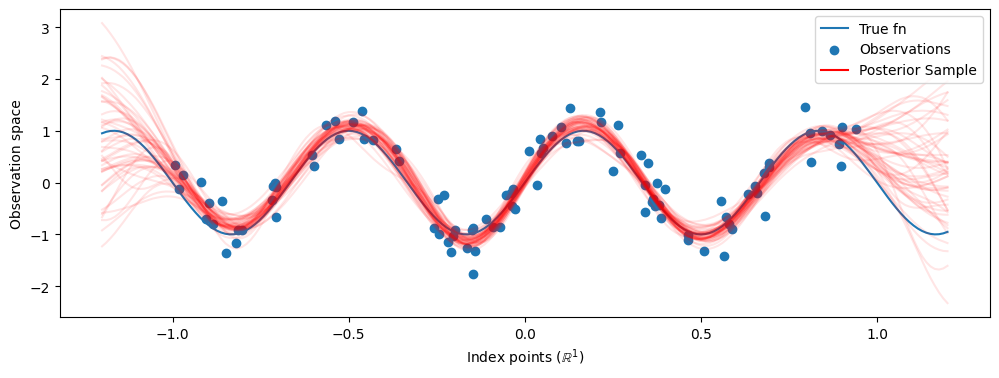

In [7]:
amplitude_samples = tf.reshape(self.posterior['amplitude'], -1)
length_scale_samples = tf.reshape(self.posterior['length_scale'],-1)
observation_noise_variance_samples = tf.reshape(self.posterior['observation_noise_variance'],-1)
num_results = 2000

predictive_index_points_ = np.linspace(-1.2, 1.2, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# The sampled hyperparams have a leading batch dimension, `[num_results, ...]`,
# so they construct a *batch* of kernels.
batch_of_posterior_kernels = tfk.ExponentiatedQuadratic(
    amplitude_samples, length_scale_samples)

# The batch of kernels creates a batch of GP predictive models, one for each
# posterior sample.
batch_gprm = tfd.GaussianProcessRegressionModel(
    kernel=batch_of_posterior_kernels,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variance_samples,
    predictive_noise_variance=0.)

# To construct the marginal predictive distribution, we average with uniform
# weight over the posterior samples.
predictive_gprm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(logits=tf.zeros([num_results])),
    components_distribution=batch_gprm)

num_samples = 50
samples = predictive_gprm.sample(num_samples)

# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 4))
plt.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')
for i in range(num_samples):
  plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

## 23.2. Rethinking example

In [15]:
import pyreadr
Dmat = pyreadr.read_r('./data/islandsDistMatrix.rda')
Dmat['islandsDistMatrix']

,Malekula,Tikopia,Santa Cruz,Yap,Lau Fiji,Trobriand,Chuuk,Manus,Tonga,Hawaii
Malekula,0.000,0.475,0.631,4.363,1.234,2.036,3.178,2.794,1.860,5.678
Tikopia,0.475,0.000,0.315,4.173,1.236,2.007,2.877,2.670,1.965,5.283
Santa Cruz,0.631,0.315,0.000,3.859,1.550,1.708,2.588,2.356,2.279,5.401
Yap,4.363,4.173,3.859,0.000,5.391,2.462,1.555,1.616,6.136,7.178
Lau Fiji,1.234,1.236,1.550,5.391,0.000,3.219,4.027,3.906,0.763,4.884
Trobriand,2.036,2.007,1.708,2.462,3.219,0.000,1.801,0.850,3.893,6.653
Chuuk,3.178,2.877,2.588,1.555,4.027,1.801,0.000,1.213,4.789,5.787
Manus,2.794,2.670,2.356,1.616,3.906,0.850,1.213,0.000,4.622,6.722
Tonga,1.860,1.965,2.279,6.136,0.763,3.893,4.789,4.622,0.000,5.037
Hawaii,5.678,5.283,5.401,7.178,4.884,6.653,5.787,6.722,5.037,0.000
